**EDA**

In [4]:
# Importing libraries
import os
import json
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [5]:
# Saving the memory by allocating only as much GPU memory as required for each operation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
# Using Kaggle API to upload dataset
!pip install kaggle

In [7]:
kaggle = json.load(open('kaggle.json'))

In [8]:
os.environ['KAGGLE_USERNAME'] = kaggle['username']
os.environ['KAGGLE_KEY'] = kaggle['key']

In [9]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100% 2.04G/2.04G [01:09<00:00, 33.7MB/s]
100% 2.04G/2.04G [01:09<00:00, 31.7MB/s]


In [10]:
with ZipFile('plantvillage-dataset.zip', 'r') as zip_ref:
  zip_ref.extractall()

In [11]:
# Subdirectories of plantvillage dataset and classes of 'color' subdirectory
print(os.listdir("plantvillage dataset"))
print(len(os.listdir("plantvillage dataset/color")))

['grayscale', 'color', 'segmented']
38


**Data preprocessing**

In [12]:
# Reading and using only directory with colorful images
df = 'plantvillage dataset/color'

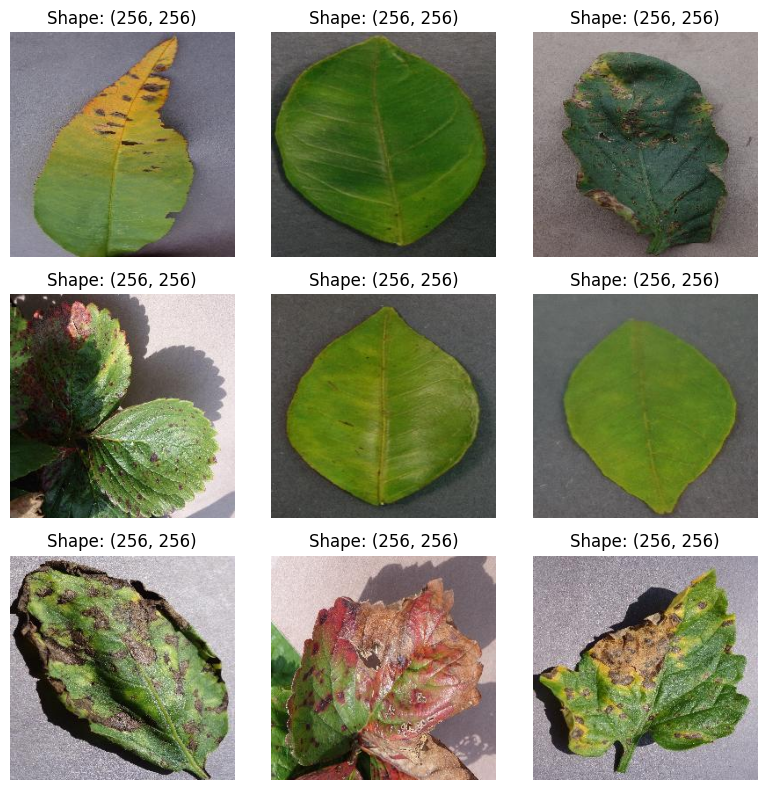

In [13]:
# Visualizing 9 random images
import random
image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(df) for f in filenames if f.lower().endswith(('png', 'jpg', 'jpeg'))]

selected_paths = random.sample(image_paths, 9)

plt.figure(figsize=(8, 8))
for i, path in enumerate(selected_paths):
    img = Image.open(path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f'Shape: {img.size}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
# Image parameters
img_size = 224
batch_size = 32

In [15]:
# Creating an instance of ImageDataGenerator for normalization and splitting
data_gen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

In [16]:
# Generating batches of data for training
train_gen = data_gen.flow_from_directory(
    df,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    subset = 'training',
    class_mode = 'categorical'
)

Found 43456 images belonging to 38 classes.


In [17]:
# Generating batches of data for validation
validation_gen = data_gen.flow_from_directory(
    df,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    subset = 'validation',
    class_mode = 'categorical'
)

Found 10849 images belonging to 38 classes.


**Building a model**

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(train_gen.num_classes, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 93312)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,944,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,954,054 (45.60 MB)

 Trainable params: 11,954,054 (45.60 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
# Train the model
history = model.fit(
    train_gen,
    epochs=5,
    validation_data=validation_gen
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2238s 2s/step - accuracy: 0.5720 - loss: 1.6364 - val_accuracy: 0.8475 - val_loss: 0.4957
Epoch 2/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2207s 2s/step - accuracy: 0.8905 - loss: 0.3599 - val_accuracy: 0.8615 - val_loss: 0.4495
Epoch 3/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2163s 2s/step - accuracy: 0.9447 - loss: 0.1776 - val_accuracy: 0.8748 - val_loss: 0.4351
Epoch 4/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2182s 2s/step - accuracy: 0.9680 - loss: 0.1000 - val_accuracy: 0.8597 - val_loss: 0.5399
Epoch 5/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2197s 2s/step - accuracy: 0.9774 - loss: 0.0722 - val_accuracy: 0.8590 - val_loss: 0.5861


**Model Evaluation**

In [23]:
val_loss, val_accuracy = model.evaluate(validation_gen)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

340/340 ━━━━━━━━━━━━━━━━━━━━ 165s 486ms/step - accuracy: 0.8573 - loss: 0.5792
Validation Accuracy: 85.90%


In [ ]:
plt.figure(figsize=(12, 5))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
#Saving classes
class_indices = {v: k for k, v in train_gen.class_indices.items()}
json.dump(class_indices, open('class_indices.json', 'w'))

In [26]:
print(class_indices)

{0: 'Apple___Apple_scab', 1: 'Apple___Black_rot', 2: 'Apple___Cedar_apple_rust', 3: 'Apple___healthy', 4: 'Blueberry___healthy', 5: 'Cherry_(including_sour)___Powdery_mildew', 6: 'Cherry_(including_sour)___healthy', 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 8: 'Corn_(maize)___Common_rust_', 9: 'Corn_(maize)___Northern_Leaf_Blight', 10: 'Corn_(maize)___healthy', 11: 'Grape___Black_rot', 12: 'Grape___Esca_(Black_Measles)', 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 14: 'Grape___healthy', 15: 'Orange___Haunglongbing_(Citrus_greening)', 16: 'Peach___Bacterial_spot', 17: 'Peach___healthy', 18: 'Pepper,_bell___Bacterial_spot', 19: 'Pepper,_bell___healthy', 20: 'Potato___Early_blight', 21: 'Potato___Late_blight', 22: 'Potato___healthy', 23: 'Raspberry___healthy', 24: 'Soybean___healthy', 25: 'Squash___Powdery_mildew', 26: 'Strawberry___Leaf_scorch', 27: 'Strawberry___healthy', 28: 'Tomato___Bacterial_spot', 29: 'Tomato___Early_blight', 30: 'Tomato___Late_blight', 31: 'To

In [27]:
# Function to load and preprocess the image
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype('float32') / 255.
    return img_array

# Function to predict the class
def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name

In [28]:
# Test case
image_path = '/content/plantvillage dataset/color/Apple___Black_rot/02186b4f-a9e1-4d19-ae3d-6cfb0f4b106a___JR_FrgE.S 2828.JPG'
predicted_class_name = predict_image_class(model, image_path, class_indices)
print("Predicted Class Name:", predicted_class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Predicted Class Name: Apple___Black_rot


In [29]:
# Saving the model
model.save('plant_disease_prediction_model.h5')